In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
def get_data(name, cols=None, fmt=None, skipfooter=0):
    df = pd.read_csv(name, engine='python',skipfooter=skipfooter)
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format=fmt)
    if cols is None:
        return df
    else:
        return df[cols]
        
data = get_data("data-220020013.csv")
data = data.dropna(how='any')

In [4]:
data.head()

,fund_1,fund_2,fund_3,fund_4,fund_5,fund_6,fund_7,fund_8,fund_9,fund_10
Date,,,,,,,,,,
2009-03-31,0.029,0.001,-0.137,-0.147,-0.064,-0.114,-0.1019,-0.0308,-0.1102,0.1067
2009-06-30,0.416,0.443,0.660,0.662,0.475,0.491,0.4290,0.3243,0.0381,-0.0405
2009-09-30,0.192,0.234,0.305,0.157,0.274,0.198,0.1004,0.2067,0.0066,0.0776
2009-12-31,-0.002,-0.002,0.141,-0.002,-0.002,0.056,-0.0106,0.0739,0.0207,0.0668
2010-03-31,0.034,0.019,0.092,0.046,0.054,0.018,-0.0079,0.0322,0.0091,-0.0242


# Try [cvxpy](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/mean_variance.html)  [参考](https://hudsonthames.org/portfolio-optimisation-with-mlfinlab-mean-variance-optimisation/)

!pip install cvxpy

In [5]:
import cvxpy as cp

## Efficient Return

For this solution, the objective is to maximise the portfolio return given a target risk value by the investor. This is very similar to the efficient_risk solution. The optimiser will find the set of weights which efficiently try to maximise return constrained by the provided target risk, hence the name “efficient return”.

In [6]:
data.mean()

fund_1     0.039049
fund_2     0.037306
fund_3     0.057404
fund_4     0.046604
fund_5     0.039430
fund_6     0.043906
fund_7     0.026451
fund_8     0.034362
fund_9     0.017449
fund_10    0.024913
dtype: float64

In [8]:
#Non-CVXPY Variables
non_cvxpy_variables = {
        'asset_prices': data,
        'num_assets': data.shape[1],
        'covariance': data.cov(),
        'asset_names': data.columns,
        'expected_returns': data.mean()
}
cvxpy_variables = [
        'risk = cp.quad_form(weights, covariance)',
        'portfolio_return = cp.matmul(weights, expected_returns)'
]

In [10]:
custom_obj = 'cp.Maximize(portfolio_return)'
constraints = ['cp.sum(weights) == 1', 'weights >= 0', 'weights <= 1', 'risk <= 0.2']

!pip install mlfinlab

In [11]:
from mlfinlab.portfolio_optimization import MeanVarianceOptimisation

In [13]:
mvo_custom_portfolio = MeanVarianceOptimisation()
mvo_custom_portfolio.allocate_custom_objective(non_cvxpy_variables=non_cvxpy_variables,
                                               cvxpy_variables=cvxpy_variables,
                                               objective_function=custom_obj,
                                               constraints=constraints)
mvo_custom_weights = mvo_custom_portfolio.weights
y_pos = np.arange(len(mvo_custom_weights.columns))

In [14]:
mvo_custom_weights

,fund_1,fund_2,fund_3,fund_4,fund_5,fund_6,fund_7,fund_8,fund_9,fund_10
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


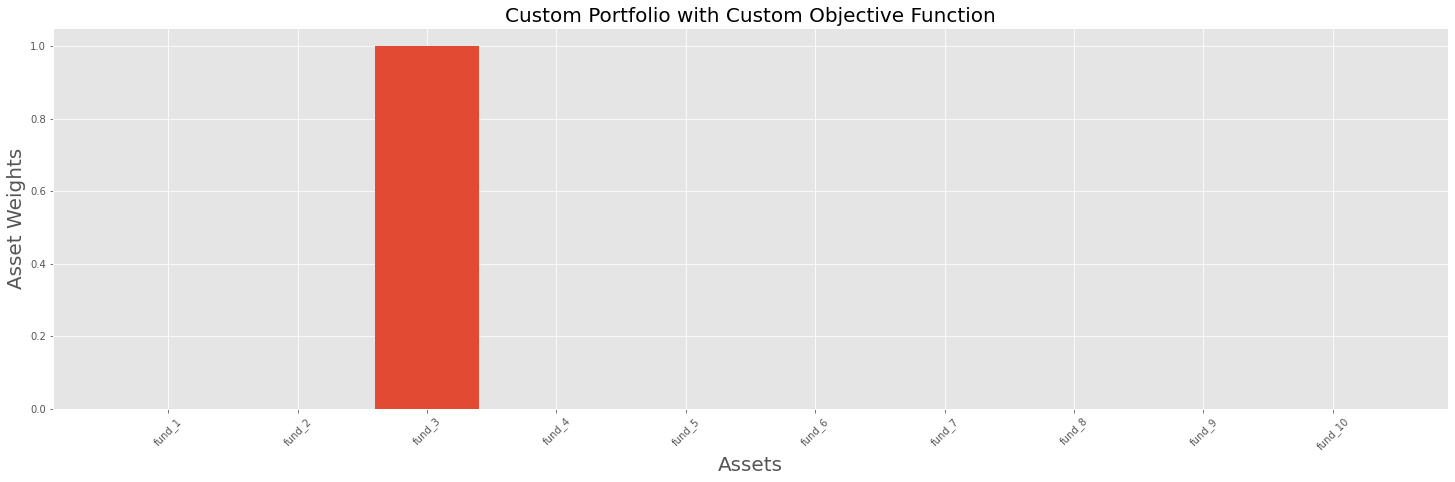

In [15]:
plt.figure(figsize=(25,7))
plt.bar(list(mvo_custom_weights.columns), mvo_custom_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Custom Portfolio with Custom Objective Function', size=20)
plt.show()

In [16]:
from mlfinlab.portfolio_optimization import ReturnsEstimators

In [17]:
data.head()

,fund_1,fund_2,fund_3,fund_4,fund_5,fund_6,fund_7,fund_8,fund_9,fund_10
Date,,,,,,,,,,
2009-03-31,0.029,0.001,-0.137,-0.147,-0.064,-0.114,-0.1019,-0.0308,-0.1102,0.1067
2009-06-30,0.416,0.443,0.660,0.662,0.475,0.491,0.4290,0.3243,0.0381,-0.0405
2009-09-30,0.192,0.234,0.305,0.157,0.274,0.198,0.1004,0.2067,0.0066,0.0776
2009-12-31,-0.002,-0.002,0.141,-0.002,-0.002,0.056,-0.0106,0.0739,0.0207,0.0668
2010-03-31,0.034,0.019,0.092,0.046,0.054,0.018,-0.0079,0.0322,0.0091,-0.0242


In [18]:
ret_est = ReturnsEstimators()

y_weights = {}

res=pd.DataFrame()

ap = data.loc[f'{year}-03-31':f'{year}-12-31']

rets = ret_est.calculate_returns(ap) 

cov = rets.cov()

#-------- You can replace with any scheme/solution you wish

mvo = MeanVarianceOptimisation()

mvo.allocate(asset_prices=ap, covariance_matrix=cov, target_return = 0.05,solution='efficient_risk')

y_weights[year] = np.array(mvo.weights).flatten()

#-------------------------------------------------

epr = np.dot(rets.mean(), y_weights[year].T) * 252 

epv = np.dot(y_weights[year].T, np.dot(rets.cov() * 252, y_weights[year].T)) ** 0.5 

esr = epr/epv 

ap1 = df.loc[f'{year + 1}-01-01':f'{year + 1}-12-31']

rets1 = ret_est.calculate_returns(ap1)

rpv = np.dot(y_weights[year].T, np.dot(rets1.cov() * 252, y_weights[year].T)) ** 0.5

rpr = np.dot(rets1.mean(), y_weights[year].T) * 252

rsr = rpr / rpv

res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,'rpv': rpv, 'rpr': rpr, 'rsr': rsr},index=[year + 1]))

display(res, pd.DataFrame(res.mean()))



SyntaxError: invalid character in identifier (<ipython-input-18-24861e98316f>, line 9)

In [ ]:
rebal_days = ['2014/09/30','2015/09/30','2016/09/30','2017/09/30','2018/09/30','2019/09/30']
rebal_days = [pd.to_datetime(x) for x in rebal_days]

port_value = pd.DataFrame(index=[rebal_days[0]], data=[[100]], columns=["Risk Parity"])
port_value_eq = pd.DataFrame(index=[rebal_days[0]], data=[[100]], columns=["Equal Weight"])

In [ ]:
for rebal_date, next_date in zip(rebal_days[:-1],rebal_days[1:]):
    train_start_date = rebal_date - pd.DateOffset(years=1)#years=5
    train_data = data.loc[train_start_date:rebal_date]
    cov = train_data.cov().values
    w_star = get_weight(cov)
    asset_return = data.loc[rebal_date:next_date]
    port_value = record_results(w_star, asset_return, port_value)
    w_eq = np.array([1/10]*10)
    port_value_eq = record_results(w_eq, asset_return, port_value_eq)

In [20]:
data2 = pd.read_excel('stock.xlsx')

In [21]:
data2.head()

,Date,150270.OF,150050.OF,150149.OF,150258.OF
0,2016-01-04,0.720,1.297,0.684,1.422
1,2016-01-05,0.699,1.267,0.631,1.360
2,2016-01-06,0.709,1.299,0.645,1.365
3,2016-01-07,0.638,1.225,0.581,1.287
4,2016-01-08,0.606,1.230,0.545,1.170


In [40]:
def get_data2(name, cols=None, fmt=None, skipfooter=0):
    df = pd.read_excel(name)
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format=fmt)
    if cols is None:
        return df
    else:
        return df[cols]
        
data2 = get_data2("stock.xlsx")
data2 = data2.dropna(how='any')

In [41]:
data2

,150270.OF,150050.OF,150149.OF,150258.OF
Date,,,,
2016-01-04,0.720,1.297,0.684,1.422
2016-01-05,0.699,1.267,0.631,1.360
2016-01-06,0.709,1.299,0.645,1.365
2016-01-07,0.638,1.225,0.581,1.287
2016-01-08,0.606,1.230,0.545,1.170
...,...,...,...,...
2020-11-10,1.363,2.299,1.574,1.138
2020-11-11,1.384,2.298,1.505,1.112
2020-11-12,1.421,2.271,1.526,1.110


In [42]:
#Non-CVXPY Variables
non_cvxpy_variables = {
        'asset_prices': data2,
        'num_assets': data2.shape[1],
        'covariance': data2.cov(),
        'asset_names': data2.columns,
        'expected_returns': data2.mean()
}
cvxpy_variables = [
        'risk = cp.quad_form(weights, covariance)',
        'portfolio_return = cp.matmul(weights, expected_returns)'
]

In [43]:
data2.shape[1]

4

In [45]:
custom_obj = 'cp.Maximize(portfolio_return)'
constraints = ['cp.sum(weights) == 1', 'weights >= 0', 'weights <= 1', 'risk <= 0.1']

In [46]:
mvo_custom_portfolio = MeanVarianceOptimisation()
mvo_custom_portfolio.allocate_custom_objective(non_cvxpy_variables=non_cvxpy_variables,
                                               cvxpy_variables=cvxpy_variables,
                                               objective_function=custom_obj,
                                               constraints=constraints)

In [47]:
mvo_custom_weights = mvo_custom_portfolio.weights
y_pos = np.arange(len(mvo_custom_weights.columns))

In [48]:
mvo_custom_weights

,150270.OF,150050.OF,150149.OF,150258.OF
0,0.179172,0.548547,1.801286e-10,0.272281


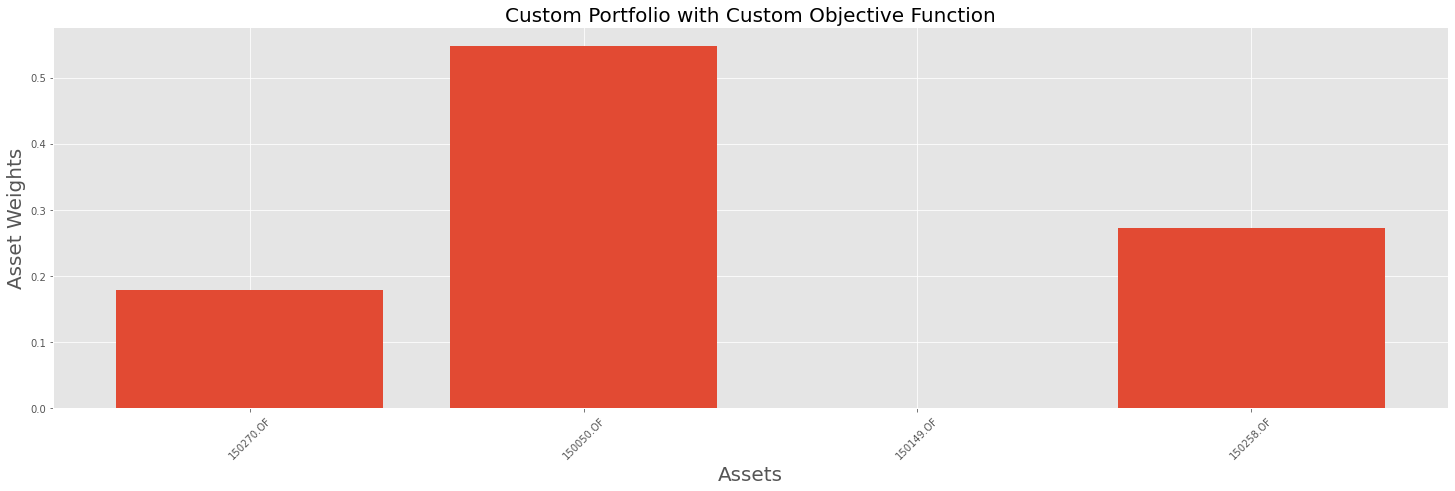

In [49]:
plt.figure(figsize=(25,7))
plt.bar(list(mvo_custom_weights.columns), mvo_custom_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Custom Portfolio with Custom Objective Function', size=20)
plt.show()